# Dataset & dataloader

In [ ]:
from transformers import AutoTokenizer, AutoModel

# tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

In [2]:
'''import pickle

def write_list(filename, to_store):
    with open(filename, 'wb') as fp:
        pickle.dump(to_store, fp)

def read_list(filename):
    with open(filename, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list''';

In [3]:
from torch.utils.data import Dataset

class TripletDataset(Dataset):

    def __init__(self, anchor, positive, negative, score, tokenizer, max_len):
        self.anchor = anchor
        self.positive = positive
        self.negative = negative
        self.score = score
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.anchor)

    def __getitem__(self, item):

        anchor = str(self.anchor[item])
        # anchor = read_list(f'anchors/{str(self.anchor[item])}.pickle')
        # anchor = read_list(f'anchors/{str(self.anchor[item])}.pickle')[-1]
        positive = str(self.positive[item])
        negative = str(self.negative[item])
        score = self.score[item]

        anchor_encoding = self.tokenizer(
            anchor,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )

        positive_encoding = self.tokenizer(
            positive,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )

        negative_encoding = self.tokenizer(
            negative,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )

        return {
            'anchor': anchor,
            'positive': positive,
            'negative': negative,
            'anchor_ids': anchor_encoding['input_ids'].flatten(),
            'anchor_attention_mask': anchor_encoding['attention_mask'].flatten(),
            'positive_ids': positive_encoding['input_ids'].flatten(),
            'positive_attention_mask': positive_encoding['attention_mask'].flatten(),
            'negative_ids': negative_encoding['input_ids'].flatten(),
            'negative_attention_mask': negative_encoding['attention_mask'].flatten(),
            'score': score,
        }

In [4]:
import pandas as pd
# df = pd.read_csv('data/triplets_cities_with_context_scores.csv')
df = pd.read_csv('data/triplets_cities_context_onestr_scores.csv')
df.shape

(8723, 7)

In [5]:
from torch.utils.data import random_split
import torch

ds = TripletDataset(
        #anchor=df.anchor.to_numpy(),
        anchor=df.anchor_one_str.to_numpy(),
        positive=df.positive.to_numpy(),
        negative=df.negative.to_numpy(),
        score=df.score,
        tokenizer=tokenizer,
        max_len=2048
    )

#train_size = int(0.8 * len(ds))
#val_size = int(0.1 * len(ds))
#test_size = len(ds) - train_size - val_size
val_size = int(0.07 * len(ds))
train_size = len(ds) - val_size

generator = torch.Generator() # fixing random seed 
generator.manual_seed(0)

# train_dataset, val_dataset, test_dataset = random_split(ds, [train_size, val_size, test_size], generator=generator)
train_dataset, val_dataset = random_split(ds, [train_size, val_size], generator=generator)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
#print('{:>5,} testing samples'.format(test_size))

8,113 training samples
  610 validation samples


In [6]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 6

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [ ]:
#indices = list(test_dataset.indices)
indices = list(val_dataset.indices)
df_test = df.iloc[indices]
#df_test.to_csv('data/test_onestr.csv')
df_test.to_csv('data/val_onestr.csv')
df_test.head()

# Train

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cuda"

In [11]:
from transformers import AutoTokenizer, AutoModel 

# model_anchor = AutoModel.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")
# model_pos_neg = AutoModel.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")
model_anchor = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
model_pos_neg = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

model_anchor = model_anchor.to(device)
model_pos_neg = model_pos_neg.to(device)

In [ ]:
from transformers import AdamW

optimizer_a = AdamW(model_anchor.parameters(), lr = 2e-5, eps = 1e-8)
optimizer_pn = AdamW(model_pos_neg.parameters(), lr = 2e-5, eps = 1e-8)

In [13]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

#scheduler = get_linear_schedule_with_warmup(optimizer,
#                                            num_warmup_steps = 0,
#                                            num_training_steps = total_steps)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TripletLoss(nn.Module):
    def __init__(self, margin = 1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.cosine = nn.CosineSimilarity(dim=1, eps=1e-6)

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def calc_cosine(self,x1,x2):
        return self.cosine(x1,x2)

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative_a = self.calc_euclidean(anchor, negative)
        distance_negative_b = self.calc_euclidean(positive, negative)
        
        losses = torch.relu(distance_positive - (distance_negative_a + distance_negative_b)/2.0 + self.margin)

        return losses.mean()

class SoftmaxLoss(nn.Module):
    def __init__(self, alpha=1.0):
        super(SoftmaxLoss, self).__init__()
        self.alpha=alpha

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        pos_sim = torch.sum(anchor * positive, dim=1, keepdim=True)
        neg_mul = torch.matmul(anchor, negative.t())
        neg_sim = torch.logsumexp(neg_mul, dim=1, keepdim=True)

        loss = torch.relu(neg_sim - pos_sim + self.alpha)

        return loss.mean()
    
class SoftmaxLossRScore(nn.Module):
    def __init__(self, alpha=1.0):
        super(SoftmaxLossRScore, self).__init__()
        self.alpha=alpha

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor, r_score) -> torch.Tensor:
        pos_sim = torch.sum(anchor * positive, dim=1, keepdim=True)
        neg_mul = torch.matmul(anchor, negative.t())
        neg_sim = torch.logsumexp(neg_mul, dim=1, keepdim=True)

        loss = torch.relu(neg_sim - pos_sim + r_score + self.alpha)

        return loss.mean()
    
class TripletMarginLossRScore(nn.Module):
    def __init__(self, margin = 1.0):
        super(TripletMarginLossRScore, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return(x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor, r_score) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        
        losses = torch.relu(distance_positive - distance_negative + self.margin + r_score)

        return losses.mean()

In [15]:
# loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)
# loss_fn = TripletLoss()
loss_fn = SoftmaxLoss()
# loss_fn = TripletMarginLossRScore(margin=1.0)

In [16]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [17]:
def embed_bert_cls(model_output):
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings

In [18]:
torch.cuda.empty_cache()

In [19]:
import random
import numpy as np
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0.0
    train_losses = []

    model_anchor.train()
    model_pos_neg.train()

    for step, batch in enumerate(train_dataloader):
        optimizer_a.zero_grad()
        optimizer_pn.zero_grad()

        # Anchor
        anchor_ids = batch["anchor_ids"].to(device)
        anchor_attention_mask = batch["anchor_attention_mask"].to(device)
        anchor_outputs = model_anchor(
            input_ids=anchor_ids,
            attention_mask=anchor_attention_mask
        )
        anchor_outputs = embed_bert_cls(anchor_outputs)
        
        # Positive
        positive_ids = batch["positive_ids"].to(device)
        positive_attention_mask = batch["positive_attention_mask"].to(device)

        positive_outputs = model_pos_neg(
            input_ids=positive_ids,
            attention_mask=positive_attention_mask
        )
        positive_outputs = embed_bert_cls(positive_outputs)
        
        # Negative
        negative_ids = batch["negative_ids"].to(device)
        negative_attention_mask = batch["negative_attention_mask"].to(device)

        negative_outputs = model_pos_neg(
            input_ids=negative_ids,
            attention_mask=negative_attention_mask
        )
        negative_outputs = embed_bert_cls(negative_outputs)
        
        # Loss
        # r_score = batch["score"].to(device)
        # loss = loss_fn(anchor_outputs, positive_outputs, negative_outputs, r_score)
        loss = loss_fn(anchor_outputs, positive_outputs, negative_outputs)
        total_train_loss += loss.detach()
        loss.backward()
        
        train_losses.append(float(loss))
        
        nn.utils.clip_grad_norm_(model_anchor.parameters(), 1.0)
        nn.utils.clip_grad_norm_(model_pos_neg.parameters(), 1.0)

        optimizer_a.step()
        optimizer_pn.step()

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            print(f"  Loss at step {step} = {loss} \n")

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("")
    print("Running Validation...")
    t0 = time.time()
    
    model_anchor.eval()
    model_pos_neg.eval()
    
    with torch.no_grad():
        total_val_loss = 0.0
        val_losses = []
        for step, batch in enumerate(validation_dataloader):
            # Anchor
            anchor_ids = batch["anchor_ids"].to(device)
            anchor_attention_mask = batch["anchor_attention_mask"].to(device)
            anchor_outputs = model_anchor(
                input_ids=anchor_ids,
                attention_mask=anchor_attention_mask
            )
            anchor_outputs = embed_bert_cls(anchor_outputs)
            
            # Positive
            positive_ids = batch["positive_ids"].to(device)
            positive_attention_mask = batch["positive_attention_mask"].to(device)
            positive_outputs = model_pos_neg(
                input_ids=positive_ids,
                attention_mask=positive_attention_mask
            )
            positive_outputs = embed_bert_cls(positive_outputs)
            
            # Negative
            negative_ids = batch["negative_ids"].to(device)
            negative_attention_mask = batch["negative_attention_mask"].to(device)
            negative_outputs = model_pos_neg(
                input_ids=negative_ids,
                attention_mask=negative_attention_mask
            )
            negative_outputs = embed_bert_cls(negative_outputs)
            
            # Loss
            # r_score = batch["score"].to(device)
            # loss = loss_fn(anchor_outputs, positive_outputs, negative_outputs, r_score)
            loss = loss_fn(anchor_outputs, positive_outputs, negative_outputs)
            total_val_loss += loss.detach()
            val_losses.append(float(loss))
            
        avg_val_loss = total_val_loss / len(validation_dataloader)
        validation_time = format_time(time.time() - t0)
        
        print(f"Validation Loss: {avg_val_loss}")
        print("  Validation took: {:}".format(validation_time))

        
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': float(avg_train_loss),
            'Valid. Loss': float(avg_val_loss),
            'List of train losses': train_losses,
            'List of val losses': val_losses,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,353.    Elapsed: 0:00:24.
  Loss at step 40 = 2.6389541625976562 

  Batch    80  of  1,353.    Elapsed: 0:00:45.
  Loss at step 80 = 2.7701315879821777 

  Batch   120  of  1,353.    Elapsed: 0:01:06.
  Loss at step 120 = 2.6020660400390625 

  Batch   160  of  1,353.    Elapsed: 0:01:27.
  Loss at step 160 = 2.5876665115356445 

  Batch   200  of  1,353.    Elapsed: 0:01:48.
  Loss at step 200 = 2.9084606170654297 

  Batch   240  of  1,353.    Elapsed: 0:02:09.
  Loss at step 240 = 2.808382034301758 

  Batch   280  of  1,353.    Elapsed: 0:02:30.
  Loss at step 280 = 2.4787988662719727 

  Batch   320  of  1,353.    Elapsed: 0:02:51.
  Loss at step 320 = 2.5107340812683105 

  Batch   360  of  1,353.    Elapsed: 0:03:12.
  Loss at step 360 = 2.3588805198669434 

  Batch   400  of  1,353.    Elapsed: 0:03:33.
  Loss at step 400 = 2.4587924480438232 

  Batch   440  of  1,353.    Elapsed: 0:03:54.
  Loss at step 440 = 2.

In [20]:
version = '_tiny2_context_softmax_final'

In [21]:
torch.save(model_anchor.state_dict(), f"models/model_anchor{version}.bin")
torch.save(model_pos_neg.state_dict(), f"models/model_pos_neg{version}.bin")

In [22]:
import json
with open(f'log/training_stats{version}.json', 'w') as fout:
    json.dump(training_stats, fout)

In [23]:
all_train_losses = []
all_val_losses = []
for i in range(epochs):
    all_train_losses += training_stats[i]['List of train losses']
    all_val_losses += training_stats[i]['List of val losses']

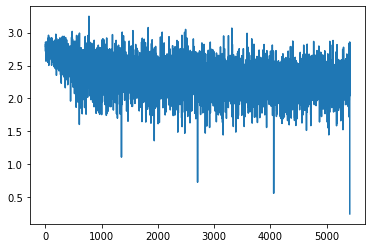

In [24]:
import matplotlib.pyplot as plt

xs = [x for x in range(len(all_train_losses))]
plt.plot(xs, all_train_losses)
plt.show()
plt.close()

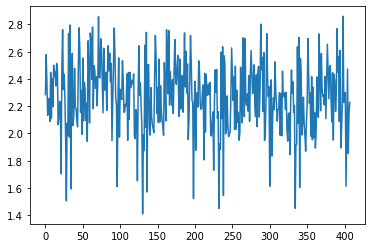

In [25]:
import matplotlib.pyplot as plt

xs = [x for x in range(len(all_val_losses))]
plt.plot(xs, all_val_losses)
plt.show()
plt.close()

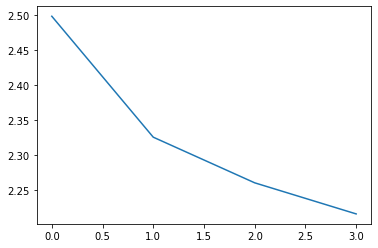

In [26]:
ys = [training_stats[i]['Training Loss'] for i in range(epochs)]
xs = [i for i in range(epochs)]
plt.plot(xs, ys)
plt.show()
plt.close()

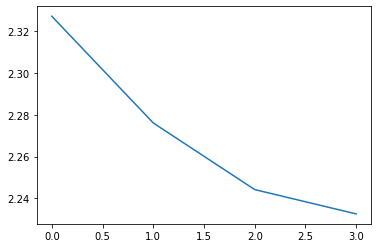

In [27]:
ys = [training_stats[i]['Valid. Loss'] for i in range(epochs)]
xs = [i for i in range(epochs)]
plt.plot(xs, ys)
plt.show()
plt.close()

In [28]:
model_test = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
model_test.load_state_dict(torch.load(f'models/model_anchor{version}.bin'))

<All keys matched successfully>

In [29]:
model_test.load_state_dict(torch.load(f'models/model_pos_neg{version}.bin'))

<All keys matched successfully>